In [40]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [123]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

In [157]:
## Preprocessing

def one_hot_jet_num(tX, idx=-1):
 
    #extract the jet_num column
    one_hot = tX[:,idx].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot

""" -- Data cleaning -- """

def cross_validation_ridge(y, x, k_indices, k, lambda_):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    mse, w = ridge_regression(y_train, x_train, lambda_)
    
    """
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

def cross_validation_ridge_3split(pred_0, pred_1, pred_2,
                                  dat_0_, dat_1_, dat_2_,
                                  inds_0, inds_1, inds_2,
                                  k_indices, k,lambda_):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]
    
    #optimized value for lambda for each jet_num subset
    loss, w_0 = ridge_regression(y_tr_0, x_tr_0, lambda_[0])
    loss, w_1 = ridge_regression(y_tr_1, x_tr_1, lambda_[1])
    loss, w_2 = ridge_regression(y_tr_2, x_tr_2, lambda_[2])   
    
    """
    loss_tr = compute_mse_3split(y_tr_0, y_tr_1, y_tr_2,
                                 x_tr_0, x_tr_1, x_tr_2,
                                 idx_tr_0, idx_tr_1, idx_tr_2,
                                 [w_0,w_1,w_2])
    loss_te = compute_mse_3split(y_te_0, y_te_1, y_te_2,
                                 x_te_0, x_te_1, x_te_2,
                                 idx_te_0, idx_te_1, idx_te_2,
                                 [w_0,w_1,w_2])
    """
    
    loss_tr = compute_acc_3split(y_tr_0, y_tr_1, y_tr_2,
                                 x_tr_0, x_tr_1, x_tr_2,
                                 idx_tr_0, idx_tr_1, idx_tr_2,
                                 [w_0,w_1,w_2])
    loss_te = compute_acc_3split(y_te_0, y_te_1, y_te_2,
                                 x_te_0, x_te_1, x_te_2,
                                 idx_te_0, idx_te_1, idx_te_2,
                                 [w_0,w_1,w_2])
    return loss_tr, loss_te, [w_0,w_1,w_2]

def cross_validation_ls(y, x, k_indices, k):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    w, loss = least_squares(y_train, x_train)
    
    """
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

def cross_validation_ls_3split(pred_0, pred_1, pred_2,
                               dat_0_, dat_1_, dat_2_,
                               inds_0, inds_1, inds_2,
                               k_indices, k):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]

    w_0, loss = least_squares(y_tr_0, x_tr_0)
    w_1, loss = least_squares(y_tr_1, x_tr_1)
    w_2, loss = least_squares(y_tr_2, x_tr_2)
    
    """
    loss_tr = compute_mse_3split(y_tr_0, y_tr_1, y_tr_2,
                                 x_tr_0, x_tr_1, x_tr_2,
                                 idx_tr_0, idx_tr_1, idx_tr_2,
                                 [w_0,w_1,w_2])
    loss_te = compute_mse_3split(y_te_0, y_te_1, y_te_2,
                                 x_te_0, x_te_1, x_te_2,
                                 idx_te_0, idx_te_1, idx_te_2,
                                 [w_0,w_1,w_2])
    """
    
    loss_tr = compute_acc_3split(y_tr_0, y_tr_1, y_tr_2,
                                 x_tr_0, x_tr_1, x_tr_2,
                                 idx_tr_0, idx_tr_1, idx_tr_2,
                                 [w_0,w_1,w_2])
    loss_te = compute_acc_3split(y_te_0, y_te_1, y_te_2,
                                 x_te_0, x_te_1, x_te_2,
                                 idx_te_0, idx_te_1, idx_te_2,
                                 [w_0,w_1,w_2])
    
    return loss_tr, loss_te, [w_0,w_1,w_2]

def cross_validation_ls_4split(pred_0, pred_1, pred_2, pred_3,
                               dat_0_, dat_1_, dat_2_, dat_3_,
                               inds_0, inds_1, inds_2, inds_3,
                               k_indices, k):
    
    idx_te_0 = np.where(np.in1d(inds_0, k_indices[k]))[0]
    idx_te_1 = np.where(np.in1d(inds_1, k_indices[k]))[0]
    idx_te_2 = np.where(np.in1d(inds_2, k_indices[k]))[0]
    idx_te_3 = np.where(np.in1d(inds_3, k_indices[k]))[0]

    x_te_0 = dat_0_[idx_te_0]
    x_te_1 = dat_1_[idx_te_1]
    x_te_2 = dat_2_[idx_te_2]
    x_te_3 = dat_3_[idx_te_3]

    y_te_0 = pred_0[idx_te_0]
    y_te_1 = pred_1[idx_te_1]
    y_te_2 = pred_2[idx_te_2]
    y_te_3 = pred_3[idx_te_3]

    
    idx_train = list(set(range(len(dat_0_)+len(dat_1_)+len(dat_2_)+len(dat_3_))) - set(k_indices[k]))
    idx_tr_0 = np.where(np.in1d(inds_0, idx_train))[0]
    idx_tr_1 = np.where(np.in1d(inds_1, idx_train))[0]
    idx_tr_2 = np.where(np.in1d(inds_2, idx_train))[0]
    idx_tr_3 = np.where(np.in1d(inds_3, idx_train))[0]

    x_tr_0 = dat_0_[idx_tr_0]
    x_tr_1 = dat_1_[idx_tr_1]
    x_tr_2 = dat_2_[idx_tr_2]
    x_tr_3 = dat_3_[idx_tr_3]

    y_tr_0 = pred_0[idx_tr_0]
    y_tr_1 = pred_1[idx_tr_1]
    y_tr_2 = pred_2[idx_tr_2]
    y_tr_3 = pred_3[idx_tr_3]


    w_0, loss = least_squares(y_tr_0, x_tr_0)
    w_1, loss = least_squares(y_tr_1, x_tr_1)
    w_2, loss = least_squares(y_tr_2, x_tr_2)
    w_3, loss = least_squares(y_tr_3, x_tr_3)

        
    loss_tr = compute_mse_4split(y_tr_0, y_tr_1, y_tr_2, y_tr_3,
                                 x_tr_0, x_tr_1, x_tr_2, x_tr_3,
                                 idx_tr_0, idx_tr_1, idx_tr_2, idx_tr_3,
                                 [w_0,w_1,w_2,w_3])
    loss_te = compute_mse_4split(y_te_0, y_te_1, y_te_2,y_te_3,
                                 x_te_0, x_te_1, x_te_2,x_te_3,
                                 idx_te_0, idx_te_1, idx_te_2, idx_te_3,
                                 [w_0,w_1,w_2,w_3])
    
    return loss_tr, loss_te, [w_0,w_1,w_2,w_3]

def cross_validation_logreg(y, x, k_indices, k, gamma, steps):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    #starting with random weights
    w = np.random.rand(x_train.shape[1],)
    for step in range(steps):
        loss, w = learning_by_gradient_descent(y_train, x_train, w, gamma)
    
    """
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    """
    loss_tr = compute_acc(y_train,x_train,w)
    loss_te = compute_acc(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

def compute_mse_3split(pred_0, pred_1, pred_2,
                       x_0, x_1, x_2,
                       inds_0, inds_1, inds_2,
                       w):
    """Calculate the loss using mse."""
        
    y_pred_0 = predict_labels(w[0], x_0)
    y_pred_1 = predict_labels(w[1], x_1)
    y_pred_2 = predict_labels(w[2], x_2)
    
    #replacing the prediction in fornt of the original idx
    pred = np.array(list(y_pred_0)+list(y_pred_1)+list(y_pred_2))

    #recreate the initial y
    y = np.array(list(pred_0)+list(pred_1)+list(pred_2))

    losses = np.empty((y.shape[0]))
    error = y - pred
    cte = 1/(2*y.shape[0])
    losses = cte*np.dot(error.T,error)
    
    return losses

def compute_acc_3split(pred_0, pred_1, pred_2,
                       x_0, x_1, x_2,
                       inds_0, inds_1, inds_2,
                       w):
    """Calculate the loss using mse."""
        
    y_pred_0 = predict_labels(w[0], x_0)
    y_pred_1 = predict_labels(w[1], x_1)
    y_pred_2 = predict_labels(w[2], x_2)
    
    #replacing the prediction in fornt of the original idx
    pred = np.array(list(y_pred_0)+list(y_pred_1)+list(y_pred_2))

    #recreate the initial y
    y = np.array(list(pred_0)+list(pred_1)+list(pred_2))
    
    tmp = pred*y
    return tmp[np.where(tmp==1)].shape[0]/tmp.shape[0]

def compute_acc(y, tx, w):
    """Calculate the loss using mse."""
    
    pred = predict_labels(w, tx)
    tmp = pred*y
    return tmp[np.where(tmp==1)].shape[0]/tmp.shape[0]

In [201]:
from implementations import *

#move jet_num to the last position
tX.T[[22,-1]] = tX.T[[-1,22]]
tX[tX == -999] = np.nan
print(tX[1,-3:])

tX = cols_log_transform(tX)
print(tX[1,-3:])
deg = 7

tX_ = np.zeros([tX.shape[0], (tX.shape[1]-1)*deg +2])
tX_[:,:-1] = build_poly(tX[:,:-1],deg)
tX_[:,-1] = tX[:,-1]

tX_[:,1:-1] = normalize_data_std(tX_[:,1:-1])

tX_md = np.ndarray.copy(tX_)
tX_me = np.ndarray.copy(tX_)
tX_ze = np.ndarray.copy(tX_)

print(tX_md[1,-3:])
print(tX_me[1,-3:])
print(tX_ze[1,-3:])

tX_md = nan_to_medi(tX_md)
tX_me = nan_to_mean(tX_me)
tX_ze = nan_to_zero(tX_ze)

print(tX_md[1,-3:])
print(tX_me[1,-3:])
print(tX_ze[1,-3:])

[nan nan  1.]
[nan nan  1.]
[nan nan  1.]


In [381]:
from implementations import *

seed = 672581
k_fold = 4
lambdas = np.logspace(-20,1,21)
degrees = 12

#putting jet_num in the last column
tX.T[[22,-1]] = tX.T[[-1,22]]
tX[tX == -999] = np.nan

#split data based on jet_num
"""WARNING tX must be unprocessed data so that the processing can
be jet_num specific WARNING""" 
#remove the jet_num column -> change the shape of the training set
pred_0, pred_1, pred_2, pred_3, dat_0, dat_1, dat_2, dat_3, inds_0, inds_1, inds_2, inds_3 = split_jet_num4(y,tX)

##prepocessing
dat_0 = cols_log_transform(dat_0)
dat_1 = cols_log_transform(dat_1)
dat_2 = cols_log_transform(dat_2)
dat_3 = cols_log_transform(dat_3)

rmse_tr_0_opt = []
rmse_te_0_opt = []
rmse_tr_1_opt = []
rmse_te_1_opt = []
rmse_tr_2_opt = []
rmse_te_2_opt = []
rmse_tr_3_opt = []
rmse_te_3_opt = []


ws_0_opt = []
ws_1_opt = []
ws_2_opt = []
ws_3_opt = []


ind_te_0_opt_lambda = 0
ind_te_1_opt_lambda = 0
ind_te_2_opt_lambda = 0
ind_te_3_opt_lambda = 0
ind_tr_0_opt_lambda = 0
ind_tr_1_opt_lambda = 0
ind_tr_2_opt_lambda = 0
ind_tr_3_opt_lambda = 0


for deg in range(1, degrees):

    """we don't have the same shape because of jet_num removal
    instead of (shape-1)*deg + 2 -> shape*deg +1"""
    dat_0_ = np.zeros([dat_0.shape[0], (dat_0.shape[1])*deg +1])
    dat_1_ = np.zeros([dat_1.shape[0], (dat_1.shape[1])*deg +1])
    dat_2_ = np.zeros([dat_2.shape[0], (dat_2.shape[1])*deg +1])
    dat_3_ = np.zeros([dat_3.shape[0], (dat_3.shape[1])*deg +1])

    dat_0_ = build_poly(dat_0,deg)
    dat_1_ = build_poly(dat_1,deg)
    dat_2_ = build_poly(dat_2,deg)
    dat_3_ = build_poly(dat_3,deg)

    #we don't standardize the first column because its the constant
    #introduced by the build_poly
    dat_0_[:,1:] = normalize_data_std(dat_0_[:,1:])
    dat_1_[:,1:] = normalize_data_std(dat_1_[:,1:])
    dat_2_[:,1:] = normalize_data_std(dat_2_[:,1:])
    dat_3_[:,1:] = normalize_data_std(dat_3_[:,1:])

    dat_0_ = nan_to_medi(dat_0_)
    dat_1_ = nan_to_medi(dat_1_)
    dat_2_ = nan_to_medi(dat_2_)
    dat_3_ = nan_to_medi(dat_3_)

    #remove column with nan
    dat_0_ = drop_nan_col(dat_0_)
    dat_1_ = drop_nan_col(dat_1_)
    dat_2_ = drop_nan_col(dat_2_)
    dat_3_ = drop_nan_col(dat_3_)

    print(dat_0_.shape[1])

    # split data in k fold
    k_indices_0 = build_k_indices(pred_0, k_fold, seed)
    k_indices_1 = build_k_indices(pred_1, k_fold, seed)
    k_indices_2 = build_k_indices(pred_2, k_fold, seed)
    k_indices_3 = build_k_indices(pred_3, k_fold, seed)

    rmse_tr_0 = []
    rmse_te_0 = []
    rmse_tr_1 = []
    rmse_te_1 = []
    rmse_tr_2 = []
    rmse_te_2 = []
    rmse_tr_3 = []
    rmse_te_3 = []

    ws_0 =[]
    ws_1 =[]
    ws_2 =[]
    ws_3 =[]

    #for lambda_ in lambdas:
    for lambda_ in lambdas:
        rmse_tr_tmp_0 = []
        rmse_te_tmp_0 = []
        rmse_tr_tmp_1 = []
        rmse_te_tmp_1 = []
        rmse_tr_tmp_2 = []
        rmse_te_tmp_2 = []
        rmse_tr_tmp_3 = []
        rmse_te_tmp_3 = []
        
        for k in range(k_fold):
            loss_tr_0, loss_te_0, w_0 = cross_validation_ridge(pred_0, dat_0_, k_indices_0, k, lambda_)
            loss_tr_1, loss_te_1, w_1 = cross_validation_ridge(pred_1, dat_1_, k_indices_1, k, lambda_)
            loss_tr_2, loss_te_2, w_2 = cross_validation_ridge(pred_2, dat_2_, k_indices_2, k, lambda_)
            loss_tr_3, loss_te_3, w_3 = cross_validation_ridge(pred_3, dat_3_, k_indices_3, k, lambda_)

            rmse_tr_tmp_0.append(loss_tr_0)
            rmse_te_tmp_0.append(loss_te_0)
            rmse_tr_tmp_1.append(loss_tr_1)
            rmse_te_tmp_1.append(loss_te_1)
            rmse_tr_tmp_2.append(loss_tr_2)
            rmse_te_tmp_2.append(loss_te_2)
            rmse_tr_tmp_3.append(loss_tr_3)
            rmse_te_tmp_3.append(loss_te_3)
        ws_0.append(w_0)
        ws_1.append(w_1)
        ws_2.append(w_2)
        ws_3.append(w_3)

        #combine the loss over the folds
        rmse_tr_0.append(np.mean(rmse_tr_tmp_0))
        rmse_te_0.append(np.mean(rmse_te_tmp_0))
        rmse_tr_1.append(np.mean(rmse_tr_tmp_1))
        rmse_te_1.append(np.mean(rmse_te_tmp_1))
        rmse_tr_2.append(np.mean(rmse_tr_tmp_2))
        rmse_te_2.append(np.mean(rmse_te_tmp_2))
        rmse_tr_3.append(np.mean(rmse_tr_tmp_3))
        rmse_te_3.append(np.mean(rmse_te_tmp_3))

        #Index all the optimal lambda
        ind_tr_0_opt_lambda = np.argmin(rmse_tr_0)
        ind_te_0_opt_lambda = np.argmin(rmse_te_0)
        ind_tr_1_opt_lambda = np.argmin(rmse_tr_1)
        ind_te_1_opt_lambda = np.argmin(rmse_te_1)
        ind_tr_2_opt_lambda = np.argmin(rmse_tr_2)
        ind_te_2_opt_lambda = np.argmin(rmse_te_2)
        ind_tr_3_opt_lambda = np.argmin(rmse_tr_3)
        ind_te_3_opt_lambda = np.argmin(rmse_te_3)
        
    #Store the optimal weights for each category (0,1 or 2)
    ws_0_opt.append(ws_0[ind_te_0_opt_lambda])
    ws_1_opt.append(ws_1[ind_te_1_opt_lambda])
    ws_2_opt.append(ws_2[ind_te_2_opt_lambda])
    ws_3_opt.append(ws_3[ind_te_3_opt_lambda])

    #Define the optimal degree and lambda for each category (0,1 or 2)
    rmse_tr_0_opt.append(rmse_tr_0[ind_tr_0_opt_lambda])
    rmse_te_0_opt.append(rmse_te_0[ind_te_0_opt_lambda])
    rmse_tr_1_opt.append(rmse_tr_1[ind_tr_1_opt_lambda])
    rmse_te_1_opt.append(rmse_te_1[ind_te_1_opt_lambda])
    rmse_tr_2_opt.append(rmse_tr_2[ind_tr_2_opt_lambda])
    rmse_te_2_opt.append(rmse_te_2[ind_te_2_opt_lambda])
    rmse_tr_3_opt.append(rmse_tr_3[ind_tr_3_opt_lambda])
    rmse_te_3_opt.append(rmse_te_3[ind_te_3_opt_lambda])

(99913, 20)
started
(99913, 39)
started
(99913, 58)
started
(99913, 77)
started
(99913, 96)
started
(99913, 115)
started
(99913, 134)
started
(99913, 153)
started
(99913, 172)
started
(99913, 191)
started
(99913, 210)
started


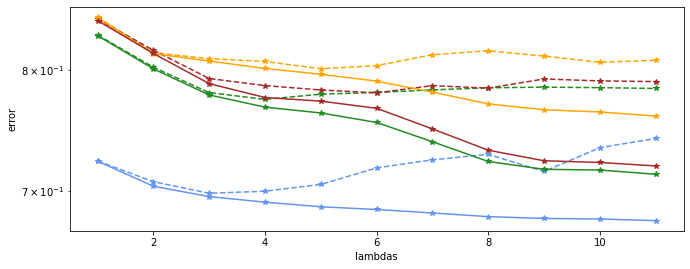

In [390]:
f = plt.figure(figsize=(11,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(1,degrees), rmse_te_0_opt, ls="--" , marker="*",
             c="cornflowerblue", label="jn 0 testing")
ax1.plot(range(1,degrees), rmse_te_1_opt, ls="--" , marker="*",
             c="orange", label="jn 1 testing")
ax1.plot(range(1,degrees), rmse_te_2_opt, ls="--" , marker="*",
             c="forestgreen", label="jn 2 testing")
ax1.plot(range(1,degrees), rmse_te_3_opt, ls="--" , marker="*",
             c="brown", label="jn 3 testing")
ax1.plot(range(1,degrees), rmse_tr_0_opt, ls="-" , marker="*",
             c="cornflowerblue", label="jn 0 training")
ax1.plot(range(1,degrees), rmse_tr_1_opt, ls="-" , marker="*",
             c="orange", label="jn 1 training")
ax1.plot(range(1,degrees), rmse_tr_2_opt, ls="-" , marker="*",
             c="forestgreen", label="jn 2 training")
ax1.plot(range(1,degrees), rmse_tr_3_opt, ls="-" , marker="*",
             c="brown", label="jn 3 training")

plt.xlabel("lambdas")
plt.ylabel("error")
plt.yscale("log")
#plt.legend()
plt.show()

In [393]:
np.argmin(rmse_te_3_opt)

5

In [ ]:
#à faire run avec degree 7 pour trouver le gamma range à 
#eventuellement affiner plus tard

seed = 12864126
k_fold = 4
gammas = np.logspace(-10,-7,6)
steps=3000

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr_md = []
rmse_te_md = []
rmse_tr_ma = []
rmse_te_ma = []
rmse_tr_ze = []
rmse_te_ze = []

ws_md = []
ws_ma = []
ws_ze = []

#for lambda_ in lambdas:
for gamma in gammas:
    rmse_tr_tmp_md = []
    rmse_te_tmp_md = []
    rmse_tr_tmp_ma = []
    rmse_te_tmp_ma = []
    rmse_tr_tmp_ze = []
    rmse_te_tmp_ze = []
    for k in range(k_fold):
        loss_tr_md, loss_te_md, w_md = cross_validation_logreg(y, tX_md, k_indices, k, gamma, steps)
        loss_tr_ma, loss_te_ma, w_ma = cross_validation_logreg(y, tX_me, k_indices, k, gamma, steps)
        loss_tr_ze, loss_te_ze, w_ze = cross_validation_logreg(y, tX_ze, k_indices, k, gamma, steps)

        rmse_tr_tmp_md.append(loss_tr_md)
        rmse_te_tmp_md.append(loss_te_md)
        rmse_tr_tmp_ma.append(loss_tr_ma)
        rmse_te_tmp_ma.append(loss_te_ma)
        rmse_tr_tmp_ze.append(loss_tr_ze)
        rmse_te_tmp_ze.append(loss_te_ze)
    ws_md.append(w_md)
    ws_ma.append(w_ma)
    ws_ze.append(w_ze)
    #combine the loss over the folds
    rmse_tr_md.append(np.mean(rmse_tr_tmp_md))
    rmse_te_md.append(np.mean(rmse_te_tmp_md))
    rmse_tr_ma.append(np.mean(rmse_tr_tmp_ma))
    rmse_te_ma.append(np.mean(rmse_te_tmp_ma))
    rmse_tr_ze.append(np.mean(rmse_tr_tmp_ze))
    rmse_te_ze.append(np.mean(rmse_te_tmp_ze))

In [ ]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.semilogx(gammas, rmse_te_md, ls="--" , marker="*", label="md")
ax1.semilogx(gammas, rmse_te_ma, ls="-" , marker="*", label="ma")
ax1.semilogx(gammas, rmse_te_ze, ls="--" , marker="*", label="ze")

plt.xlabel("gamma")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [445]:
seed = 383692
#usually 8
k_fold = 4

#lambdas for ridge
lambdas = np.logspace(-8,-6,50)
#lambdas = [10**-40]

# split data in k fold
k_indices_0 = build_k_indices(pred_0, k_fold, seed)
k_indices_1 = build_k_indices(pred_1, k_fold, seed)
k_indices_2 = build_k_indices(pred_2, k_fold, seed)

k_indices_3 = build_k_indices(pred_3, k_fold, seed)


rmse_tr_0 = []
rmse_te_0 = []
rmse_tr_1 = []
rmse_te_1 = []
rmse_tr_2 = []
rmse_te_2 = []
rmse_tr_3 = []
rmse_te_3 = []

ws_0 =[]
ws_1 =[]
ws_2 =[]
ws_3 =[]


print("started")

#for lambda_ in lambdas:
for lambda_ in lambdas:
    rmse_tr_tmp_0 = []
    rmse_te_tmp_0 = []
    rmse_tr_tmp_1 = []
    rmse_te_tmp_1 = []
    rmse_tr_tmp_2 = []
    rmse_te_tmp_2 = []
    rmse_tr_tmp_3 = []
    rmse_te_tmp_3 = []
    for k in range(k_fold):
        # ,  & 
        loss_tr_0, loss_te_0, w_0 = cross_validation_ridge(pred_0, dat_0_, k_indices_0, k, lambda_)
        loss_tr_1, loss_te_1, w_1 = cross_validation_ridge(pred_1, dat_1_, k_indices_1, k, lambda_)
        loss_tr_2, loss_te_2, w_2 = cross_validation_ridge(pred_2, dat_2_, k_indices_2, k, lambda_)
        loss_tr_3, loss_te_3, w_3 = cross_validation_ridge(pred_3, dat_3_, k_indices_3, k, lambda_)

        rmse_tr_tmp_0.append(loss_tr_0)
        rmse_te_tmp_0.append(loss_te_0)
        rmse_tr_tmp_1.append(loss_tr_1)
        rmse_te_tmp_1.append(loss_te_1)
        rmse_tr_tmp_2.append(loss_tr_2)
        rmse_te_tmp_2.append(loss_te_2)
        rmse_tr_tmp_3.append(loss_tr_3)
        rmse_te_tmp_3.append(loss_te_3)
    ws_0.append(w_0)
    ws_1.append(w_1)
    ws_2.append(w_2)
    ws_3.append(w_3)

    
    #combine the loss over the folds
    rmse_tr_0.append(np.mean(rmse_tr_tmp_0))
    rmse_te_0.append(np.mean(rmse_te_tmp_0))
    rmse_tr_1.append(np.mean(rmse_tr_tmp_1))
    rmse_te_1.append(np.mean(rmse_te_tmp_1))
    rmse_tr_2.append(np.mean(rmse_tr_tmp_2))
    rmse_te_2.append(np.mean(rmse_te_tmp_2))
    rmse_tr_3.append(np.mean(rmse_tr_tmp_3))
    rmse_te_3.append(np.mean(rmse_te_tmp_3))
    
print("finished")

started
finished


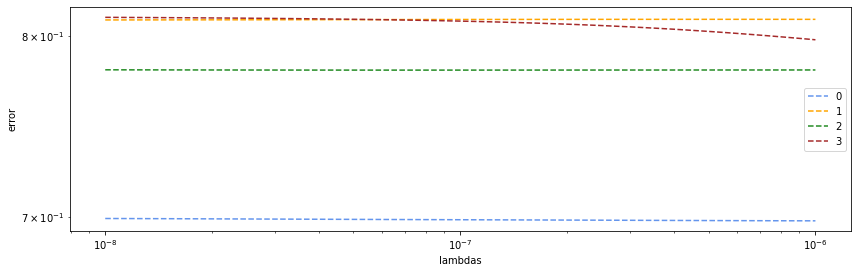

In [451]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.semilogx(lambdas, rmse_te_0, ls="--" , marker="",
             c="cornflowerblue", label="0")
ax1.semilogx(lambdas, rmse_te_1, ls="--" , marker="",
             c="orange", label="1")
ax1.semilogx(lambdas, rmse_te_2, ls="--" , marker="",
             c="forestgreen", label="2")
ax1.semilogx(lambdas, rmse_te_3, ls="--" , marker="",
             c="brown", label="3")

plt.xlabel("lambdas")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [158]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX.T[[22,-1]] = tX.T[[-1,22]]

seed = 123124512
#usually 8
k_fold = 6

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)

pred_0, pred_1, pred_2, dat_0_, dat_1_, dat_2_, inds_0, inds_1, inds_2 = preproc_3split(y,tX)

tX[tX == -999] = np.nan

tX = cols_log_transform(tX)

deg = 7

tX_ = np.zeros([tX.shape[0], (tX.shape[1]-1)*deg +2])
tX_[:,:-1] = build_poly(tX[:,:-1],deg)
tX_[:,-1] = tX[:,-1]

tX_[:,1:-1] = normalize_data_std(tX_[:,1:-1])

tX_md = np.ndarray.copy(tX_)

tX_md = nan_to_medi(tX_md)

rmse_tr_ridge3 = []
rmse_te_ridge3 = []
rmse_tr_ltsqr3 = []
rmse_te_ltsqr3 = []
rmse_tr_ltsqr = []
rmse_te_ltsqr = []
rmse_tr_ridge = []
rmse_te_ridge = []

print("started")

for k in range(k_fold):
    #using ridge to avoid singular matrix
    loss_tr_ltsqr3, loss_te_ltsqr3, w_ls3 = cross_validation_ls_3split(pred_0, pred_1, pred_2,
                                                                       dat_0_, dat_1_, dat_2_,
                                                                       inds_0, inds_1, inds_2,
                                                                       k_indices, k)
    loss_tr_ridge3, loss_te_ridge3, w_ri3 = cross_validation_ridge_3split(pred_0, pred_1, pred_2,
                                                                       dat_0_, dat_1_, dat_2_,
                                                                       inds_0, inds_1, inds_2,
                                                                       k_indices, k,
                                                                       [10**-60, 10**-60, 10**-60])
    loss_tr_ltsqr, loss_te_ltsqr, w_ls = cross_validation_ls(y, tX_md, k_indices, k)
    loss_tr_ridge, loss_te_ridge, w_ridge = cross_validation_ridge(y, tX_md, k_indices, k, 10**-4)

    
    rmse_tr_ridge3.append(loss_tr_ridge3)
    rmse_te_ridge3.append(loss_te_ridge3)
    rmse_tr_ltsqr3.append(loss_tr_ltsqr3)
    rmse_te_ltsqr3.append(loss_te_ltsqr3)
    rmse_tr_ltsqr.append(loss_tr_ltsqr)
    rmse_te_ltsqr.append(loss_te_ltsqr)
    rmse_tr_ridge.append(loss_tr_ridge)
    rmse_te_ridge.append(loss_te_ridge)

print("finished")

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:379: RuntimeWarning: Mean of empty slice
  """Standardize along features axis, implemented to ignore jet_num features."""
/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:428: RuntimeWarning: Mean of empty slice
  


started
finished


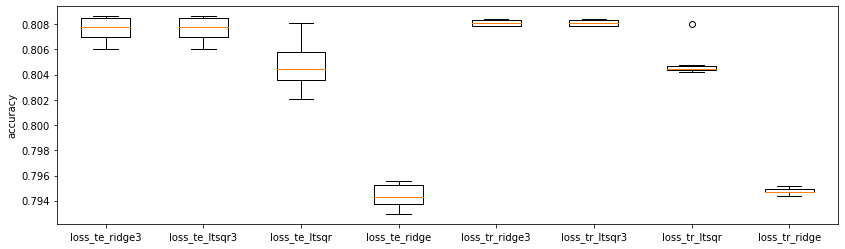

In [159]:
plt.figure(figsize=[14,4])
plt.boxplot([
             rmse_te_ridge3,
             rmse_te_ltsqr3,
             rmse_te_ltsqr,
             rmse_te_ridge,
             rmse_tr_ridge3,
             rmse_tr_ltsqr3,
             rmse_tr_ltsqr,
             rmse_tr_ridge
            ],
            labels=[
                "loss_te_ridge3",
                "loss_te_ltsqr3",
                "loss_te_ltsqr",
                "loss_te_ridge",
                "loss_tr_ridge3",
                "loss_tr_ltsqr3",
                "loss_tr_ltsqr",
                "loss_tr_ridge"
            ])
plt.ylabel("accuracy")
#plt.ylim([0.2,0.5])
plt.show()

In [160]:
#np.array(rmse_te_ltsqr3)-np.array(rmse_te_ridge3)
print(w_ls3[0][0])
print(w_ri3[0][0])

-0.4986963853606809
-0.4986963853606809


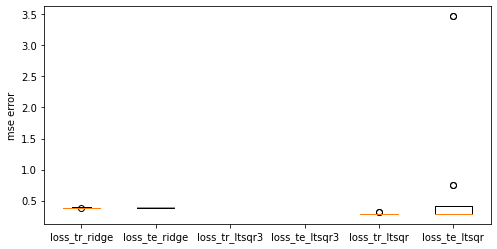

In [18]:
plt.figure(figsize=[8,4])
plt.boxplot([rmse_tr_ridge,
             rmse_te_ridge,
             rmse_tr_ltsqr3,
             rmse_te_ltsqr3,
             rmse_tr_ltsqr,
             rmse_te_ltsqr
            ],
            labels=[
                "loss_tr_ridge",
                "loss_te_ridge",
                "loss_tr_ltsqr3",
                "loss_te_ltsqr3",
                "loss_tr_ltsqr",
                "loss_te_ltsqr"
            ])
plt.ylabel("mse error")
plt.show()

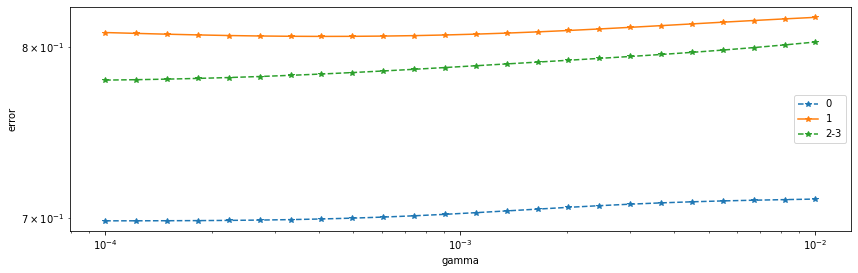

In [284]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.semilogx(lambdas, rmse_te_0, ls="--" , marker="*", label="0")
ax1.semilogx(lambdas, rmse_te_1, ls="-" , marker="*", label="1")
ax1.semilogx(lambdas, rmse_te_2, ls="--" , marker="*", label="2-3")

plt.xlabel("gamma")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [135]:
from implementations import *
"""TRAING THE MODEL WITH OPTIMIZED PARAMETERS 3 SPLITS"""
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tX.T[[22,-1]] = tX.T[[-1,22]]

#submission with 10**-4, 4.06*10**-4 & 2.72*10**-7 -> .803
#submission with 1.68*10**-6, 4.06*10**-4 & 2.72*10**-7 -> ?
pred_0, pred_1, pred_2, dat_0_, dat_1_, dat_2_, inds_0, inds_1, inds_2 = preproc_3split(y,tX)

"""
mse_0, w_0 = ridge_regression(pred_0, dat_0_, 1.68*10**-6)
mse_1, w_1 = ridge_regression(pred_1, dat_1_, 4.06*10**-4)
mse_2, w_2 = ridge_regression(pred_2, dat_2_, 2.72*10**-7)
"""
w_0, mse_0 = least_squares(pred_0, dat_0_)
w_1, mse_1 = least_squares(pred_1, dat_1_)
w_2, mse_2 = least_squares(pred_2, dat_2_)

compute_acc_3split(pred_0, pred_1, pred_2,
                       dat_0_, dat_1_, dat_2_,
                       inds_0, inds_1, inds_2,
                       [w_0,w_1,w_2])

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:379: RuntimeWarning: Mean of empty slice
  """Standardize along features axis, implemented to ignore jet_num features."""
/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:428: RuntimeWarning: Mean of empty slice
  


0.808032

"""TRAING THE MODEL WITH OPTIMIZED PARAMETERS 4 SPLITS"""
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tX.T[[22,-1]] = tX.T[[-1,22]]

#submission with 10**-4, 4.06*10**-4 & 2.72*10**-7 -> .803
#submission with 1.68*10**-6, 4.06*10**-4 & 2.72*10**-7 -> ?
pred_0, pred_1, pred_2, pred_3, dat_0_, dat_1_, dat_2_, dat_3_, inds_0, inds_1, inds_2, inds_3 = preproc_4split(y,tX)

mse_0, w_0 = ridge_regression(pred_0, dat_0_, 1.75*10**-6)
mse_1, w_1 = ridge_regression(pred_1, dat_1_, 4.09*10**-4)
mse_2, w_2 = ridge_regression(pred_2, dat_2_, 7.20*10**-8)
mse_3, w_3 = ridge_regression(pred_3, dat_3_, 1.15*10**-5)

In [113]:
print(w_0.shape[0])
print(w_1.shape[0])
print(w_2.shape[0])
#print(w_3.shape[0])
print(dat_0_.shape[1])
print(dat_1_.shape[1])
print(dat_2_.shape[1])
#print(dat_3_.shape[1])

58
89
175
58
89
175


# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

## Generate predictions and save ouput in csv format for submission:

In [114]:
from implementations import *
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.T[[22,-1]] = tX_test.T[[-1,22]]

In [115]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub17.csv'
#prediction without jet_num split
#y_pred = predict_labels(weights, tX_test_)

#prediction with jet_num 3 split
y_pred = pred_jet_num([w_0,w_1,w_2], [3,4,6], tX_test)

#prediction with jet_num 4 split
#y_pred = pred_jet_num4([w_0,w_1,w_2,w_3], [3,4,3,5], tX_test)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [117]:
y_pred

array([ 1.,  1., -1., ..., -1.,  1.,  1.])